In [96]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import os
import sys
from ipywidgets import widgets
from IPython.display import display, HTML
from IPython.display import clear_output
import matplotlib.pyplot as plt
import seaborn as sns
import scipy

# Customized modules
HOME = '/home/serinatan/project/GPU-Virtualization-Benchmarks/util'
if HOME not in sys.path:
    sys.path.append(HOME)

import data.scripts.common.format as fmt
import data.scripts.common.constants as const
import data.scripts.gen_tables.gen_pair_configs as gen_pair

SCRIPT_PATH = os.path.join(HOME, 'data/scripts') 
PKL_PATH = os.path.join(HOME, 'data/pickles') 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
def draw_table(df, cols, hide_index=True):
    if hide_index:
        return df[cols].style.set_table_styles(fmt.table_style).hide_index()
    else:
        return df[cols].style.set_table_styles(fmt.table_style)

# Pair - dynamic

In [194]:
gen_pair = os.path.join(SCRIPT_PATH, 'gen_tables/gen_table_pair.py')
baseline = 'seq'
seq_pkl = os.path.join(PKL_PATH, 'seq.pkl')
intra_pkl = os.path.join(PKL_PATH, 'intra.pkl')
csv = os.path.join(HOME, 'data/csv/pair_dynamic.csv')
output = os.path.join(PKL_PATH, 'pair_dynamic_seq.pkl')

%run $gen_pair --csv $csv --output $output --seq_pkl $seq_pkl --intra_pkl $intra_pkl 

(318, 56)
(318, 209)


In [195]:
df_dynamic = pd.read_pickle(output)
df_dynamic.sort_values(['1_bench', '2_bench'], inplace=True)
df_dynamic.reset_index(inplace=True, drop=True)
print(df_dynamic.shape)

# FIXME: drop any rows with zero fairness
df_dynamic = df_dynamic[df_dynamic['fairness'] > 0]
print(df_dynamic.shape)


(318, 209)
(313, 209)


# Prediction Model

In [136]:
from sklearn import ensemble
from sklearn import datasets
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn import tree
import numpy as np
import pydotplus
from graphviz import Source
from sklearn.model_selection import KFold

import data.scripts.common.help_iso as hi

In [198]:
# #############################################################################
# Load data
cols_prefix = ['norm_ipc', 
#                'avg_dram_bw', 
#                'avg_mem_lat', 
               'avg_rbh', 
#                'l2_miss_rate', 
               'norm_diff_mflat', 
               'diff_bw',
               'diff_mpc',
               'diff_thread',
              ]

def feature_set(suffix1, suffix2):
    df_dynamic['norm_diff_mflat_'+suffix1] = \
        (df_dynamic['avg_mem_lat_'+suffix1] - df_dynamic['avg_mem_lat_'+suffix2])\
        /df_dynamic['avg_mem_lat_'+suffix1]
    
    df_dynamic['diff_bw_'+suffix1] = \
        (df_dynamic['avg_dram_bw_'+suffix1] - df_dynamic['avg_dram_bw_'+suffix2])\
        /df_dynamic['avg_dram_bw_'+suffix1]
   
    df_dynamic['avg_rbh_'+suffix1] = df_dynamic['row_buffer_locality_'+suffix1].transform(hi.avg_array)
    
    df_dynamic['diff_mpc_'+suffix1] = (df_dynamic['mpc_'+suffix1] - df_dynamic['mpc_'+suffix2])\
        / df_dynamic['mpc_'+suffix1]

    df_dynamic['diff_thread_'+suffix1] = \
        (df_dynamic['thread_count_'+suffix1] - df_dynamic['thread_count_'+suffix2])\
            / df_dynamic['thread_count_'+suffix1]
    
    cols = cols_prefix 
    cols = [c + '_' + suffix1 for c in cols]
    X = df_dynamic[cols].values

    X = X.astype(np.float32)
    print('X invalid?', np.isnan(X).any())
    return X

X1 = feature_set('x', 'y')
X2 = feature_set('y', 'x')
X = np.concatenate((X1, X2), axis=0)


y1 = df_dynamic['1_sld']
y2 = df_dynamic['2_sld']
y = np.concatenate((y1, y2), axis=0)

X, y = shuffle(X, y, random_state=7)

print(X.shape, y.shape)
# offset = int(X.shape[0] * 0.7)
# X_train, y_train = X[:offset], y[:offset]
# X_test, y_test = X[offset:], y[offset:]

X invalid? False
X invalid? False
(626, 6) (626,)


In [205]:
# #############################################################################
# Fit regression model
err = []
kf = KFold(n_splits=5)
params = {'n_estimators': 500, 'max_depth': 5, 'min_samples_split': 2,
          'learning_rate': 0.01, 'loss': 'huber'}
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    clf = ensemble.GradientBoostingRegressor(**params)

    clf.fit(X_train, y_train)
    mse = mean_absolute_error(y_test, clf.predict(X_test))
    print(mse)
    err.append(mse)

# get the final model
X_train = X
y_train = y
clf = ensemble.GradientBoostingRegressor(**params)
clf.fit(X_train, y_train)

0.07237654836094179
0.0793113100427773
0.06708167362299867
0.06790927681314766
0.06265863583333174


GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.01, loss='huber',
                          max_depth=5, max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=500,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

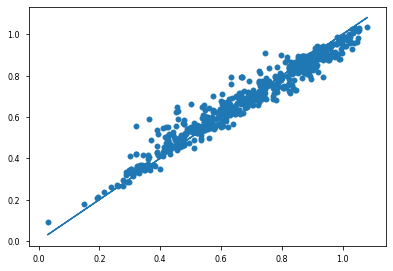

In [206]:
plt.scatter(y, clf.predict(X))
plt.plot(y, y)
plt.show()

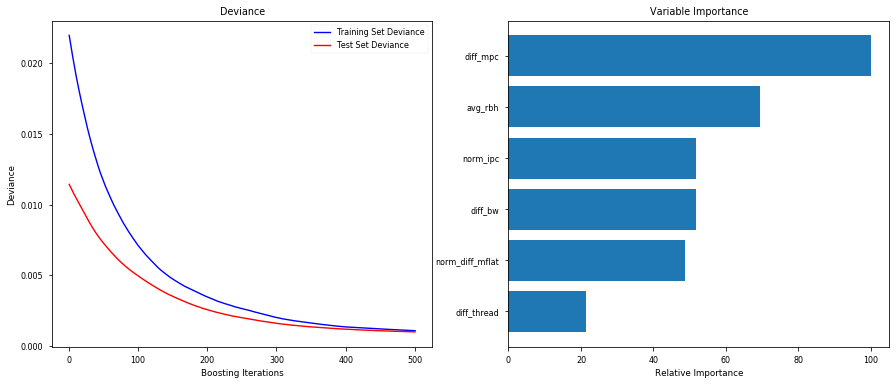

In [207]:
# #############################################################################
# Plot training deviance

# compute test set deviance
test_score = np.zeros((params['n_estimators'],), dtype=np.float64)

for i, y_pred in enumerate(clf.staged_predict(X_test)):
    test_score[i] = clf.loss_(y_test, y_pred)

plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.title('Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, clf.train_score_, 'b-',
         label='Training Set Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, test_score, 'r-',
         label='Test Set Deviance')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Deviance')

# #############################################################################
# Plot feature importance
feature_importance = clf.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
np_cols = np.array(cols_prefix)
plt.yticks(pos, np_cols[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

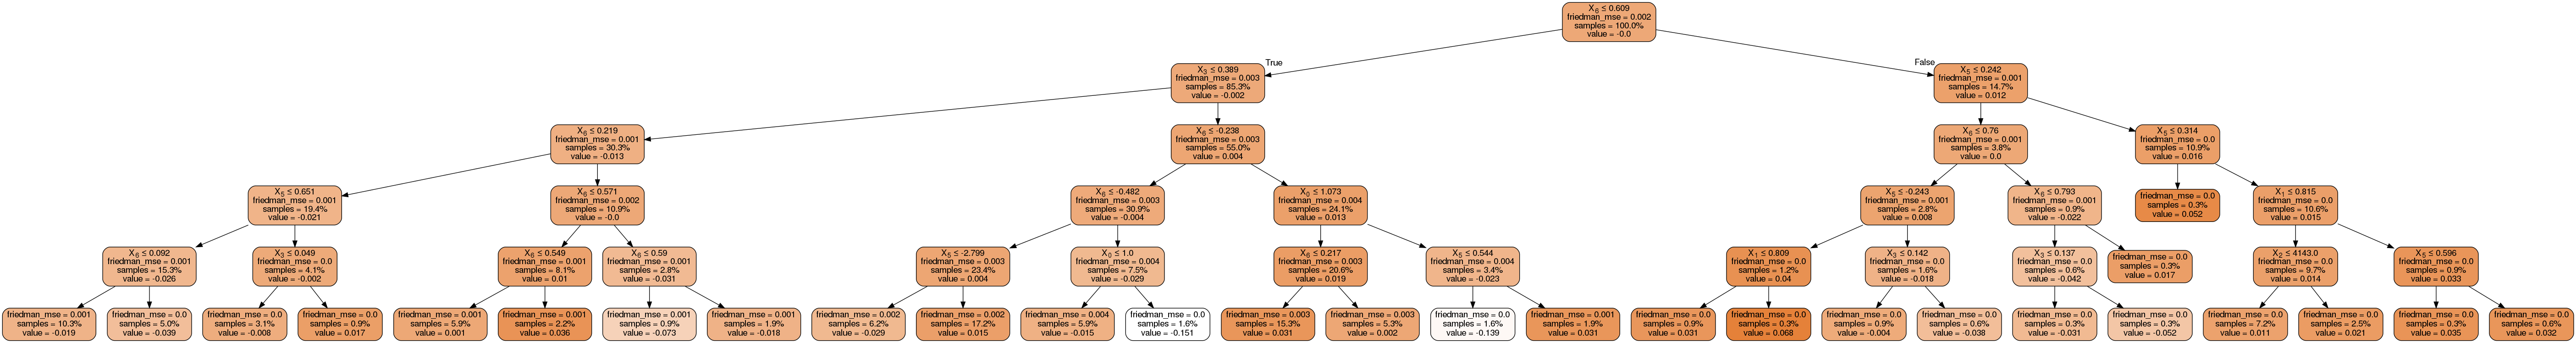

In [99]:

sub_tree_300 = clf.estimators_[300, 0]

dot_data = tree.export_graphviz(
    sub_tree_300,
    out_file=None, filled=True,
    rounded=True,  
    special_characters=True,
    proportion=True,
)


graph = Source( dot_data )
png_bytes = graph.pipe(format='png')
with open('dtree_pipe.png','wb') as f:
    f.write(png_bytes)

from IPython.display import Image
Image(png_bytes)


In [209]:
def predict(suffix):
    cols = [c + '_' + suffix for c in cols_prefix]
    X = df_dynamic[cols].values

    return clf.predict(X)
    
df_dynamic['1_predicted'] = predict('x')
df_dynamic['2_predicted'] = predict('y')
df_dynamic['1_delta'] = df_dynamic['1_predicted'] - df_dynamic['1_sld']
df_dynamic['2_delta'] = df_dynamic['2_predicted'] - df_dynamic['2_sld']

# Only show best performance for each benchmark pair
# df_dynamic_show = df_dynamic.sort_values('ws', ascending=False).drop_duplicates(['1_bench','2_bench'])
# df_dynamic_show.reset_index(inplace=True, drop=True)

col_dynamic_seq = ['1_bench', 'intra_x', 'l2_x',
                   '2_bench', 'intra_y', 'l2_y',
                   # '1_intra', '2_intra', '1_l2', '2_l2', 
#                    'norm_ipc_x', 
                   '1_sld', '1_predicted', # '1_infer', 
                   '1_delta',
#                    'norm_ipc_y', 
                   '2_sld', '2_predicted', # '2_infer', 
                   '2_delta',
#                    'ws', 'fairness', 
#                    'sum_ipc', 'diff_mflat', 'sum_dram',
                   '1_norm_mflat', '2_norm_mflat'
                  ]
def highlight_error(s):
    is_high = np.abs(s) > 0.1
    return ['background-color: yellow' if v else '' for v in is_high]

draw_table(df_dynamic, 
           col_dynamic_seq, False).apply(highlight_error, subset=['1_delta', '2_delta'])

,1_bench,intra_x,l2_x,2_bench,intra_y,l2_y,1_sld,1_predicted,1_delta,2_sld,2_predicted,2_delta,1_norm_mflat,2_norm_mflat
0,cut_sgemm-1,1,0.25,cut_wmma-0,2,0.75,0.983571,0.903168,-0.0804035,0.808275,0.740861,-0.0674147,0.918367,0.874237
1,cut_sgemm-1,1,0.5,parb_cutcp-0,2,0.5,0.916346,0.936158,0.019812,0.858277,0.85282,-0.00545672,0.382385,1.22727
2,cut_sgemm-1,1,0.25,parb_cutcp-0,2,0.75,0.916238,0.942329,0.0260912,0.858958,0.85282,-0.00613754,0.393126,1.22078
3,cut_sgemm-1,1,0.75,parb_cutcp-0,2,0.25,0.921009,0.936158,0.0151491,0.857086,0.853098,-0.00398829,0.366273,1.23377
4,cut_sgemm-1,1,0.75,parb_lbm-0,3,0.25,0.874346,0.817645,-0.0567005,0.783475,0.791304,0.00782926,1.22342,0.180007
5,cut_sgemm-1,1,0.25,parb_lbm-0,6,0.75,0.443625,0.455489,0.0118647,0.846681,0.817728,-0.0289527,2.31149,0.385553
6,cut_sgemm-1,1,0.25,parb_lbm-0,3,0.75,0.835048,0.75658,-0.0784683,0.779495,0.786319,0.00682409,1.14393,0.171927
7,cut_sgemm-1,1,0.5,parb_spmv-0,6,0.5,0.962401,0.888805,-0.0735959,0.86801,0.853684,-0.0143266,0.917293,0.625157
8,cut_sgemm-1,1,0.25,parb_spmv-0,6,0.75,0.955459,0.883892,-0.0715674,0.875704,0.857414,-0.01829,0.935553,0.615094
9,cut_sgemm-1,1,0.75,parb_spmv-0,6,0.25,0.973556,0.888805,-0.0847505,0.770327,0.738245,-0.032082,0.925886,0.722013
